# Linear Regression
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

In [177]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [57]:
df.head()

,con,level,hp,wis,cha,str,dex,int,ac,book
0,5,10,215,2,1,7,2,1,29,Pathfinder Bestiary
1,5,10,220,2,1,9,0,-4,28,Pathfinder Bestiary
2,6,8,175,3,-2,7,3,-4,25,Pathfinder Bestiary
3,5,17,315,5,6,7,4,6,41,Pathfinder Bestiary
4,1,1,20,1,1,-5,3,-1,16,Pathfinder Bestiary


## Train test split and preprocessing

In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
min_max_df = pd.DataFrame()
min_max_df[characteristics] = pd.DataFrame(scaler.fit_transform(df[characteristics]))
min_max_df["book"] = df["book"]
min_max_df["level"] = df["level"]
# min_max_df = df

In [73]:
min_max_df.head()

,cha,con,dex,int,str,wis,ac,hp,book,level
0,0.3750,0.416667,0.4375,0.400000,0.705882,0.333333,0.456522,0.386447,Pathfinder Bestiary,10
1,0.3750,0.416667,0.3125,0.066667,0.823529,0.333333,0.434783,0.395604,Pathfinder Bestiary,10
2,0.1875,0.500000,0.5000,0.066667,0.705882,0.416667,0.369565,0.313187,Pathfinder Bestiary,8
3,0.6875,0.416667,0.5625,0.733333,0.705882,0.583333,0.717391,0.569597,Pathfinder Bestiary,17
4,0.3750,0.083333,0.5000,0.266667,0.000000,0.250000,0.173913,0.029304,Pathfinder Bestiary,1


### Chronological split

In [74]:
from training.splitting_dataset import split_dataframe

os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(min_max_df, test_size=0.31)
os.chdir("../notebooks/models")

In [75]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### <font color='red'>X_train and y_train have elements of object type instead of int64. Needs fix.</font>

In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 840
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cha     841 non-null    float64
 1   con     841 non-null    float64
 2   dex     841 non-null    float64
 3   int     841 non-null    float64
 4   str     841 non-null    float64
 5   wis     841 non-null    float64
 6   ac      841 non-null    float64
 7   hp      841 non-null    float64
dtypes: float64(8)
memory usage: 59.1 KB


In [77]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype 
--------------  ----- 
841 non-null    object
dtypes: object(1)
memory usage: 13.1+ KB


### Random split

In [86]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(min_max_df, chronological_split=False, test_size=0.25)

In [87]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Linear Regression
### With chronological split

In [97]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict = model.predict(X_test)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2 = r2_score(y_train, y_pred_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.98


In [98]:
from sklearn.metrics import mean_squared_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 0.90
RMSE: 0.95


In [99]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")

RMSE train: 0.74
RMSE test: 0.95


In [100]:
round_predict = np.round(predict).astype("int")
round_predict = np.where(round_predict > 20, 21, round_predict)
threshold33 = 0.33
round_predict_lower_threshold33 = np.where(
    (predict % 1) > threshold33, np.ceil(predict), np.floor(predict)
).astype("int")
threshold45 = 0.45
round_predict_lower_threshold45 = np.where(
    (predict % 1) > threshold45, np.ceil(predict), np.floor(predict)
).astype("int")

In [101]:
def check_predictions(y, y_pred):
    print(f"Mean square error: {mean_squared_error(y, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.2f}")
    print()

In [102]:
print("Normal:")
check_predictions(y_test, predict)

print("Round:")
check_predictions(y_test, round_predict)

print("Round lower threshold = 0.33:")
check_predictions(y_test, round_predict_lower_threshold33)

print("Round lower threshold = 0.45:")
check_predictions(y_test, round_predict_lower_threshold45)

Normal:
Mean square error: 0.90
RMSE: 0.95

Round:
Mean square error: 0.85
RMSE: 0.92

Round lower threshold = 0.33:
Mean square error: 0.95
RMSE: 0.97

Round lower threshold = 0.45:
Mean square error: 0.96
RMSE: 0.98



### With random split

In [114]:
model = LinearRegression()
model.fit(X_train_random_split, y_train_random_split)
predict_train = model.predict(X_train_random_split)
predict = model.predict(X_test_random_split)

y_pred_train = model.predict(X_train_random_split)
y_pred_test = model.predict(X_test_random_split)

r2 = r2_score(y_train_random_split, y_pred_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.98


In [115]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 0.68
RMSE: 0.82


In [116]:
rmse_train = mean_squared_error(y_train_random_split, y_pred_train, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")

RMSE train: 0.79
RMSE test: 0.82


In [117]:
round_predict = np.round(predict).astype("int")
round_predict = np.where(round_predict > 20, 21, round_predict)
threshold33 = 0.33
round_predict_lower_threshold33 = np.where(
    (predict % 1) > threshold33, np.ceil(predict), np.floor(predict)
).astype("int")
threshold45 = 0.45
round_predict_lower_threshold45 = np.where(
    (predict % 1) > threshold45, np.ceil(predict), np.floor(predict)
).astype("int")

In [118]:
print("Normal:")
check_predictions(y_test_random_split, predict)

print("Round:")
check_predictions(y_test_random_split, round_predict)

print("Round lower threshold = 0.33:")
check_predictions(y_test_random_split, round_predict_lower_threshold33)

print("Round lower threshold = 0.45:")
check_predictions(y_test_random_split, round_predict_lower_threshold45)

Normal:
Mean square error: 0.68
RMSE: 0.82

Round:
Mean square error: 0.53
RMSE: 0.73

Round lower threshold = 0.33:
Mean square error: 0.78
RMSE: 0.88

Round lower threshold = 0.45:
Mean square error: 0.75
RMSE: 0.87



### <font color='red'>===============Old notebook===============</font>

In [119]:
bestiary1 = pd.read_json("../../pathfinder_2e_data/pathfinder-bestiary.db", lines=True)
bestiary2 = pd.read_json(
    "../../pathfinder_2e_data/pathfinder-bestiary-2.db", lines=True
)
bestiary3 = pd.read_json(
    "../../pathfinder_2e_data/pathfinder-bestiary-3.db", lines=True
)

In [120]:
b = [bestiary1, bestiary2, bestiary3]

bestiary = pd.concat(b, join="outer", axis=0).fillna(np.nan)

In [121]:
print(
    (bestiary1.size + bestiary2.size + bestiary3.size) == bestiary.size
)  # sprawdzenie czy coś nie uciekło

True


In [122]:
bestiary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 364
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _id             1206 non-null   object
 1   img             1206 non-null   object
 2   items           1206 non-null   object
 3   name            1206 non-null   object
 4   system          1206 non-null   object
 5   type            1206 non-null   object
 6   flags           1206 non-null   object
 7   prototypeToken  85 non-null     object
dtypes: object(8)
memory usage: 84.8+ KB


Po połączeniu sprawdzamy czy wszystkie z rekordów to potworki - *npc*, a nie jakieś przedmioty

In [123]:
bestiary.type.unique()

array(['npc'], dtype=object)

W bestiariuszach nie ma nic oprócz bestii, więc nic nie usuwamy.

In [124]:
from copy import deepcopy


bestiary_backup = deepcopy(bestiary)

```unpack_column``` - Funkcja która rozpakowuje słownik i zmienia go w dataframe. Printuje pierwszą wartość tabeli i długość

*by P J*

In [125]:
def unpack_column(df, column_name):
    new_df = df[column_name].apply(pd.Series)
    return new_df

## Wyodrębnianie kolumny *system* i przygotowanie danych
Wszystkie potzrebne wartości znajdyją się w tej kolumnie

In [126]:
bestiary_system = unpack_column(bestiary, "system")

### Przygotowanie danych z system: *abilities*
* cha
* con
* dex
* int
* str
* wis


In [127]:
abilities = unpack_column(bestiary_system, "abilities")

for col in abilities.columns:
    for i, row in abilities.iterrows():
        row[col] = row[col].get("mod")

In [128]:
abilities.head()

,cha,con,dex,int,str,wis
0,1,5,2,1,7,2
1,1,5,0,-4,9,2
2,-2,6,3,-4,7,3
3,6,5,4,6,7,5
4,1,1,3,-1,-5,1


In [129]:
abilities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 364
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cha     1206 non-null   object
 1   con     1206 non-null   object
 2   dex     1206 non-null   object
 3   int     1206 non-null   object
 4   str     1206 non-null   object
 5   wis     1206 non-null   object
dtypes: object(6)
memory usage: 66.0+ KB


### Przygotowanie danych z attributes

In [130]:
attributes = unpack_column(bestiary_system, "attributes")

#### Przygotowanie attributes: *ac*
W modelu wykorzystamy wastość value z ac

In [131]:
attributes_ac = unpack_column(attributes, "ac")

In [132]:
attributes_ac = pd.DataFrame(data=attributes_ac.value)
attributes_ac.columns = ["ac"]

In [133]:
attributes_ac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 364
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ac      1206 non-null   int64
dtypes: int64(1)
memory usage: 18.8 KB


In [134]:
attributes_ac.head()

,ac
0,29
1,28
2,25
3,41
4,16


#### Przygotowanie attributes: *hp*
W modelu wykorzystamy wastość value z hp i jak na razie nie będziemy uwzględniać pozostałych

In [135]:
attributes_hp = unpack_column(attributes, "hp")

In [136]:
attributes_hp = pd.DataFrame(data=attributes_hp.value)
attributes_hp.columns = ["hp"]

In [137]:
attributes_hp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 364
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   hp      1206 non-null   int64
dtypes: int64(1)
memory usage: 18.8 KB


In [138]:
attributes_hp.head()

,hp
0,215
1,220
2,175
3,315
4,20


## Usunięcie niepotrzebnych wartości z oryginalnej tabeli i dodanie przygotowanych powyżej danych

In [139]:
# bestiary_copy = deepcopy(bestiary)

In [140]:
# bestiary = deepcopy(bestiary_copy)

In [141]:
# bestiary = deepcopy(bestiary_backup)

In [142]:
for col in abilities:
    bestiary[col] = abilities[col]

In [143]:
bestiary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 364
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _id             1206 non-null   object
 1   img             1206 non-null   object
 2   items           1206 non-null   object
 3   name            1206 non-null   object
 4   system          1206 non-null   object
 5   type            1206 non-null   object
 6   flags           1206 non-null   object
 7   prototypeToken  85 non-null     object
 8   cha             1206 non-null   object
 9   con             1206 non-null   object
 10  dex             1206 non-null   object
 11  int             1206 non-null   object
 12  str             1206 non-null   object
 13  wis             1206 non-null   object
dtypes: object(14)
memory usage: 141.3+ KB


In [144]:
bestiary["ac"] = attributes_ac

In [145]:
bestiary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 364
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _id             1206 non-null   object
 1   img             1206 non-null   object
 2   items           1206 non-null   object
 3   name            1206 non-null   object
 4   system          1206 non-null   object
 5   type            1206 non-null   object
 6   flags           1206 non-null   object
 7   prototypeToken  85 non-null     object
 8   cha             1206 non-null   object
 9   con             1206 non-null   object
 10  dex             1206 non-null   object
 11  int             1206 non-null   object
 12  str             1206 non-null   object
 13  wis             1206 non-null   object
 14  ac              1206 non-null   int64 
dtypes: int64(1), object(14)
memory usage: 150.8+ KB


In [146]:
bestiary["hp"] = attributes_hp

In [147]:
bestiary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 364
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _id             1206 non-null   object
 1   img             1206 non-null   object
 2   items           1206 non-null   object
 3   name            1206 non-null   object
 4   system          1206 non-null   object
 5   type            1206 non-null   object
 6   flags           1206 non-null   object
 7   prototypeToken  85 non-null     object
 8   cha             1206 non-null   object
 9   con             1206 non-null   object
 10  dex             1206 non-null   object
 11  int             1206 non-null   object
 12  str             1206 non-null   object
 13  wis             1206 non-null   object
 14  ac              1206 non-null   int64 
 15  hp              1206 non-null   int64 
dtypes: int64(2), object(14)
memory usage: 160.2+ KB


In [148]:
bestiary.drop("prototypeToken", axis=1, inplace=True)
bestiary.drop("flags", axis=1, inplace=True)
bestiary.drop("type", axis=1, inplace=True)
bestiary.drop("system", axis=1, inplace=True)
bestiary.drop("name", axis=1, inplace=True)
bestiary.drop("items", axis=1, inplace=True)
bestiary.drop("img", axis=1, inplace=True)
bestiary.drop("_id", axis=1, inplace=True)

In [149]:
bestiary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 364
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cha     1206 non-null   object
 1   con     1206 non-null   object
 2   dex     1206 non-null   object
 3   int     1206 non-null   object
 4   str     1206 non-null   object
 5   wis     1206 non-null   object
 6   ac      1206 non-null   int64 
 7   hp      1206 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 84.8+ KB


In [150]:
bestiary.head()

,cha,con,dex,int,str,wis,ac,hp
0,1,5,2,1,7,2,29,215
1,1,5,0,-4,9,2,28,220
2,-2,6,3,-4,7,3,25,175
3,6,5,4,6,7,5,41,315
4,1,1,3,-1,-5,1,16,20


## Wyobrębnienie wartości przewidywanej *level*

In [151]:
level = unpack_column(unpack_column(bestiary_system, "details"), "level")

In [152]:
level.columns = ["level"]

In [153]:
level.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 364
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   level   1206 non-null   int64
dtypes: int64(1)
memory usage: 18.8 KB


In [154]:
print(level)

     level
0       10
1       10
2        8
3       17
4        1
..     ...
360     20
361     -1
362     12
363      6
364      6

[1206 rows x 1 columns]


In [155]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for i, lvl in level["level"].items():
    lvl_stat[lvl] += 1

In [156]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
print(level_count)

    lvl  count
0    -1     34
1     0     27
2     1    127
3     2    121
4     3     95
5     4     82
6     5     76
7     6     72
8     7     77
9     8     68
10    9     63
11   10     58
12   11     40
13   12     41
14   13     36
15   14     33
16   15     31
17   16     25
18   17     21
19   18     21
20   19     18
21   20     24
22   21      8
23   22      1
24   23      4
25   24      2
26   25      1


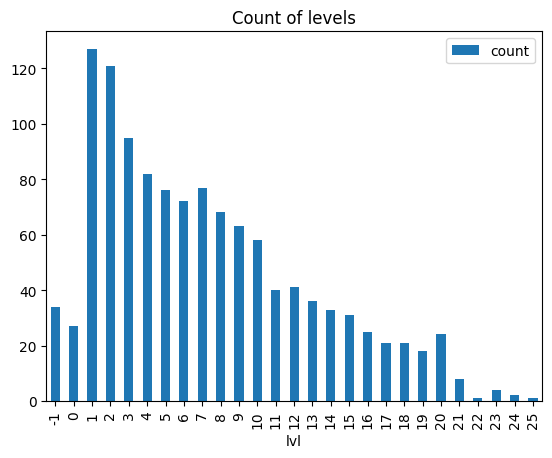

In [157]:
import matplotlib.pyplot as plt

level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

In [158]:
level.head()

,level
0,10
1,10
2,8
3,17
4,1


## Podział na zbiór treningowy i testowy

In [168]:
X = deepcopy(bestiary)
y = deepcopy(level)
print(X.head())
print(y.head())

  cha con dex int str wis  ac   hp
0   1   5   2   1   7   2  29  215
1   1   5   0  -4   9   2  28  220
2  -2   6   3  -4   7   3  25  175
3   6   5   4   6   7   5  41  315
4   1   1   3  -1  -5   1  16   20
   level
0     10
1     10
2      8
3     17
4      1


### Skalowanie

In [240]:
from sklearn.preprocessing import MinMaxScaler

data_columns = X.columns
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = data_columns

print(X.head())
print(y.head())

      cha       con     dex       int       str       wis        ac        hp
0  0.3750  0.416667  0.4375  0.400000  0.705882  0.333333  0.456522  0.386447
1  0.3750  0.416667  0.3125  0.066667  0.823529  0.333333  0.434783  0.395604
2  0.1875  0.500000  0.5000  0.066667  0.705882  0.416667  0.369565  0.313187
3  0.6875  0.416667  0.5625  0.733333  0.705882  0.583333  0.717391  0.569597
4  0.3750  0.083333  0.5000  0.266667  0.000000  0.250000  0.173913  0.029304
   level
0     10
1     10
2      8
3     17
4      1


In [244]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, shuffle=True
)

## Regresja liniowa

In [245]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict = model.predict(X_test)

## Sprawdzenie modelu

In [246]:
from sklearn.metrics import r2_score

predict_train = model.predict(X_train)
r2 = r2_score(y_train, predict_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.98


R2 jest blisko 1, więc model jest dobrze dostosowany do danych

In [247]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predict)
rmse = mean_squared_error(y_test, predict, squared=False)
print(f"Mean square error: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

Mean square error: 0.59
RMSE: 0.77


RMSE nie jest najgorsze, ale dobrze by było jakby było mniejsze

In [248]:
rmse_train = mean_squared_error(y_train, predict_train, squared=False)
rmse_test = mean_squared_error(y_test, predict, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.74
RMSE test: 0.77


Błąd treningowy nie jest dużo mniejszy niż testowy, więc nie mamy overfittingu.

In [111]:
from sklearn.metrics import (
    mean_absolute_error,
    median_absolute_error,
)


print(f"Mean absolute error = {mean_absolute_error(y_test, predict):.2f}")
print(f"Median absolute error = {median_absolute_error(y_test, predict):.2f}")

Mean absolute error = 0.53
Median absolute error = 0.33


In [112]:
y_test

,level
395,4
5,7
141,13
452,8
52,10
...,...
77,13
11,0
155,13
240,13


### Sprawdzenie wyników po zaokrągleniu

In [113]:
from math import ceil, floor


round_predict = deepcopy(predict)
ceil_predict = deepcopy(predict)
floor_predict = deepcopy(predict)

for i in range(len(round_predict)):
    round_predict[i][0] = round(round_predict[i][0], 0)
    ceil_predict[i][0] = ceil(ceil_predict[i][0])
    floor_predict[i][0] = floor(floor_predict[i][0])

In [114]:
def check_predictions(y, y_pred):
    print(f"Mean square error: {mean_squared_error(y, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.2f}")
    print(f"Mean absolute error = {mean_absolute_error(y, y_pred):.2f}")
    print(f"Median absolute error = {median_absolute_error(y, y_pred):.2f}")
    print()

In [115]:
print("Normal:")
check_predictions(y_test, predict)

print("Round:")
check_predictions(y_test, round_predict)

print("Ceil:")
check_predictions(y_test, ceil_predict)

print("Floor:")
check_predictions(y_test, floor_predict)

Normal:
Mean square error: 0.59
RMSE: 0.77
Mean absolute error = 0.53
Median absolute error = 0.33

Round:
Mean square error: 0.65
RMSE: 0.80
Mean absolute error = 0.46
Median absolute error = 0.00

Ceil:
Mean square error: 0.86
RMSE: 0.93
Mean absolute error = 0.64
Median absolute error = 1.00

Floor:
Mean square error: 1.06
RMSE: 1.03
Mean absolute error = 0.76
Median absolute error = 1.00



Najlepiej klasyfikuje round.

### Macierz sąsiedztwa
Zobaczymy, które klasy są ze sobą mylone.

In [116]:
print(y["level"].unique())

[10  8 17  1  7  4  5 -1  0  9  2 20 19 16  6 18 14 13  3 25 15 11 12 21
 23 22 24]


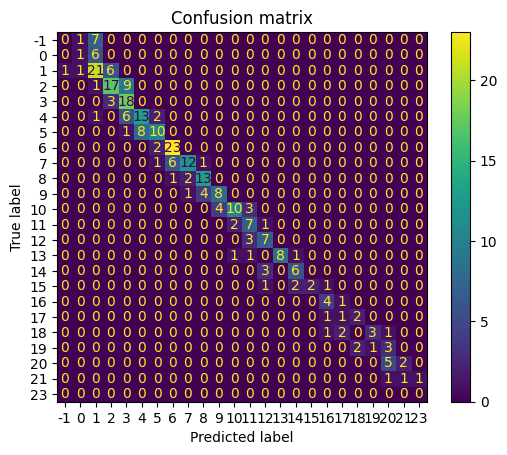

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, round_predict)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=np.unique(round_predict).astype("int")
)

disp.plot()
plt.title("Confusion matrix")
plt.show()

## Tuning

In [118]:
def assess_regression_model(model, X_train, X_test, y_train, y_test) -> None:
    # predict for train and test
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    # calculate R2
    r2 = model.score(X_train, y_train)
    # calculate train and test RMSE
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    # print train and test RMSE
    print(f"R2: {r2:.2f}")
    print(f"RMSE train: {rmse_train:.2f}")
    print(f"RMSE test: {rmse_test:.2f}")

### Regresja

In [119]:
reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

assess_regression_model(reg_linear, X_train, X_test, y_train, y_test)

R2: 0.98
RMSE train: 0.74
RMSE test: 0.77


### Tuning (regularyzacja ridge, LASSO)

In [120]:
from sklearn.linear_model import RidgeCV, LassoCV

reg_ridge_cv = RidgeCV(alphas=np.linspace(0.1, 100, 1000))
reg_lasso_cv = LassoCV(n_alphas=1000, random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train, y_train)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train,
    np.array(y_train).reshape(
        y_train.size,
    ),
)

print(f"Ridge CV alpha: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()
print("Ridge:")
assess_regression_model(reg_ridge_cv, X_train, X_test, y_train, y_test)
print()
print("Lasso:")
assess_regression_model(reg_lasso_cv, X_train, X_test, y_train, y_test)

Ridge CV alpha: 0.1000
Lasso CV alpha: 0.0067

Ridge:
R2: 0.98
RMSE train: 0.74
RMSE test: 0.77

Lasso:
R2: 0.98
RMSE train: 0.75
RMSE test: 0.79


* RMSE się nie poprawiło. 
* Alpha dla ridge i lasso wychodzą z dolnej granicy zakresu, więc bliżej przeszukamy tamte okolice.

### Sprawdzenie regularyzacji po zmianie zakresu hiperparametrów

In [121]:
from sklearn.linear_model import RidgeCV, LassoCV

reg_ridge_cv = RidgeCV(alphas=np.linspace(1e-3, 1, 10000))
reg_lasso_cv = LassoCV(alphas=np.linspace(1e-4, 1e-1, 1000), random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train, y_train)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train,
    np.array(y_train).reshape(
        y_train.size,
    ),
)

print(f"Ridge CV alphas: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()
print("Ridge:")
assess_regression_model(reg_ridge_cv, X_train, X_test, y_train, y_test)
print()
print("Lasso:")
assess_regression_model(reg_lasso_cv, X_train, X_test, y_train, y_test)

Ridge CV alphas: 0.0296
Lasso CV alpha: 0.0067

Ridge:
R2: 0.98
RMSE train: 0.74
RMSE test: 0.77

Lasso:
R2: 0.98
RMSE train: 0.75
RMSE test: 0.79


Alpha dla ridge się zmniejszyła, natomiast nie widać znaczącej poprawy wyników.

### Ocena cech

<Axes: title={'center': 'Best features'}, ylabel='feature name'>

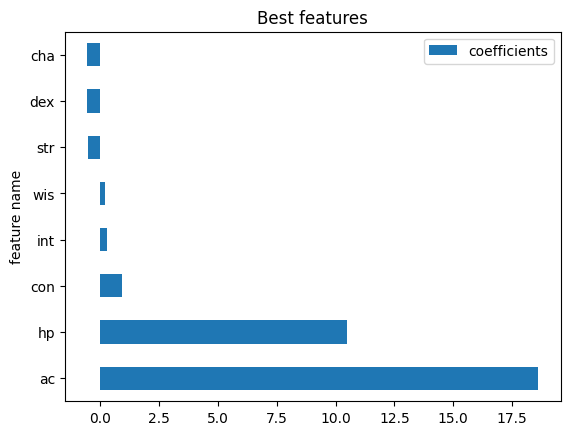

In [122]:
feature_names = X.columns

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": [feature_names[i] for i in range(len(feature_names))],
        "coefficients": [reg_ridge_cv.coef_[0, i] for i in range(len(feature_names))],
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(x="feature name", y="coefficients", title="Best features")

Ma to jakiś sens. Dziwi mnie, że atrybuty nie mają znaczenia, gdyż na ich podstawie są budowane inne statystyki, najwyraźniej inne modyfikatory dominują nad atrybutami. Dziwne, że strenght nie ma dużego znaczenia i wychodzi ujemny czyli jakby był odwrotnie proporcjonalny do CRu. Najwyraźniej modyfikator siły nie ma tak dużego znaczenia w zadawanych obrażeniach.

In [123]:
eliminated_features = sorted(feature_names[reg_lasso_cv.coef_ == 0])
print(eliminated_features)

['cha', 'dex', 'int', 'str', 'wis']


Lasso wyeliminowało nam wszystkie atrybuty oprócz constitution.

### Podsumowując
Regularyzacja nie polepszyła wyników. Napewno warto korzystać z LASSO, żeby wyeliminować jakieś cechy, natomiast gdy jest ich tylko 8 to nie jest to takie ważne.
Może dla większej ilości parametrów będzie miała więcej sensu.

### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [135]:
import sys

import os
import pathlib

sys.path.append("../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [136]:
df.head()

,dex,con,ac,hp,cha,int,reflex,will,str,focus,level,wis,book,perception,fortitude
0,2,5,29,215,1,1,19,17,7,1,10,2,Pathfinder Bestiary,20,22
1,0,5,28,220,1,-4,14,16,9,0,10,2,Pathfinder Bestiary,16,21
2,3,6,25,175,-2,-4,17,15,7,0,8,3,Pathfinder Bestiary,17,20
3,4,5,41,315,6,6,29,32,7,1,17,5,Pathfinder Bestiary,30,30
4,3,1,16,20,1,-1,10,4,-5,1,1,1,Pathfinder Bestiary,6,6


## Train test split
### Chronological split

In [151]:
from training.splitting_dataset import split_dataframe

os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models")

In [152]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [153]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 840
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dex         841 non-null    object
 1   con         841 non-null    object
 2   ac          841 non-null    object
 3   hp          841 non-null    object
 4   cha         841 non-null    object
 5   int         841 non-null    object
 6   reflex      841 non-null    object
 7   will        841 non-null    object
 8   str         841 non-null    object
 9   focus       841 non-null    object
 10  wis         841 non-null    object
 11  perception  841 non-null    object
 12  fortitude   841 non-null    object
dtypes: object(13)
memory usage: 92.0+ KB


In [154]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 841 to 1205
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   dex         365 non-null    int64
 1   con         365 non-null    int64
 2   ac          365 non-null    int64
 3   hp          365 non-null    int64
 4   cha         365 non-null    int64
 5   int         365 non-null    int64
 6   reflex      365 non-null    int64
 7   will        365 non-null    int64
 8   str         365 non-null    int64
 9   focus       365 non-null    int32
 10  wis         365 non-null    int64
 11  perception  365 non-null    int64
 12  fortitude   365 non-null    int64
dtypes: int32(1), int64(12)
memory usage: 38.5 KB


In [155]:
X_train = X_train.astype("int64")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 840
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   dex         841 non-null    int64
 1   con         841 non-null    int64
 2   ac          841 non-null    int64
 3   hp          841 non-null    int64
 4   cha         841 non-null    int64
 5   int         841 non-null    int64
 6   reflex      841 non-null    int64
 7   will        841 non-null    int64
 8   str         841 non-null    int64
 9   focus       841 non-null    int64
 10  wis         841 non-null    int64
 11  perception  841 non-null    int64
 12  fortitude   841 non-null    int64
dtypes: int64(13)
memory usage: 92.0 KB


In [156]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype 
--------------  ----- 
841 non-null    object
dtypes: object(1)
memory usage: 13.1+ KB


In [157]:
y_train = y_train.astype("int64")
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype
--------------  -----
841 non-null    int64
dtypes: int64(1)
memory usage: 13.1 KB


In [149]:
y_test.head()

841     3
842     9
843     0
844     1
845    15
Name: level, dtype: int64

### Random split

In [158]:
from training.splitting_dataset import split_dataframe

(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [159]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Linear Regression
### With chronological split

In [163]:
model = LinearRegression()
model.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict = model.predict(X_test)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2 = r2_score(y_train, y_pred_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.99


R2 larger than before (0.98)

In [164]:
mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 0.35
RMSE: 0.59


Both metrics with better results than before:
MSE: *0.59 --> 0.35*
RMSE: *0.77 --> 0.59*

In [166]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")

RMSE train: 0.51
RMSE test: 0.59


### With random split

In [169]:
model = LinearRegression()
model.fit(X_train_random_split, y_train_random_split)
predict_train = model.predict(X_train_random_split)
predict = model.predict(X_test_random_split)

y_pred_train = model.predict(X_train_random_split)
y_pred_test = model.predict(X_test_random_split)

r2 = r2_score(y_train_random_split, y_pred_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.99


In [171]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 0.33
RMSE: 0.57


In [173]:
rmse_train = mean_squared_error(y_train_random_split, y_pred_train, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")

RMSE train: 0.51
RMSE test: 0.57
